# mbo_utilities: User Guide

[**Installation**](https://millerbrainobservatory.github.io/mbo_utilities/installation.html) | 
[**User Guide**](https://millerbrainobservatory.github.io/mbo_utilities/user_guide.html) | 
[**Array Types**](https://millerbrainobservatory.github.io/mbo_utilities/array_types.html) | 
[**MBO Hub**](https://millerbrainobservatory.github.io/)

An image I/O library with an intuitive GUI for scientific imaging data.

## Reading and Writing Data

```python
# Read any supported format - returns a lazy array
arr = mbo.imread(
    inputs,      # Path, list of paths, or glob pattern
    **kwargs     # Format-specific options passed to underlying reader
)

# Write to any supported format
mbo.imwrite(
    lazy_array,              # Source array to write
    outpath,                 # Output directory or file path
    ext='.tiff',             # Output format: '.tiff', '.zarr', '.h5', '.bin', '.npy'
    planes=None,             # List of plane indices to extract (e.g. [1, 2, 3], or None = all)
    num_frames=None,         # Number of frames to write (None = all)
    register_z=False,        # Enable Suite3D axial registration
    roi=None,                # ROI selection for MboRawArray, None = stitched horizontally
    metadata=None,           # Add metadata to this file
    overwrite=False,         # Overwrite existing files
    order=None,              # Dimension order string
    target_chunk_mb=100,     # Target chunk size for zarr/h5
    output_name=None,        # WIP: Custom output filename
    **kwargs                 # Format-specific options
)
```

| Input | Array Type |
|-------|------------|
| `.tif` / `.tiff` | `TiffArray` |
| `.zarr` | `ZarrArray` |
| `.h5` / `.hdf5` | `H5Array` |
| `.npy` | `NpyArray` |
| `.bin` + `ops.npy` | `Suite2pArray` |
| Raw ScanImage `.tif` | `MboRawArray` |

In [11]:
from pathlib import Path
import numpy as np
import mbo_utilities as mbo
import matplotlib.pyplot as plt

RAW_PATH = Path(r"D:/demo/raw")
SAVE_PATH = Path(r"D:/demo/planes")

### Load a data file

This demo will use raw ScanImage tiffs.

Raw ScanImage TIFFs are detected automatically and return an `MboRawArray`:

In [12]:
arr = mbo.imread(RAW_PATH)

print(f"Type: {type(arr).__name__}")
print(f"Shape (T, Z, Y, X): {arr.shape}")
print(f"Planes: {arr.num_planes}, Frames: {arr.num_frames}, ROIs: {arr.num_rois}")

Counting frames:   0%|          | 0/2 [00:00<?, ?it/s]

Type: MboRawArray
Shape (T, Z, Y, X): (1574, 14, 550, 448)
Planes: 14, Frames: 1574, ROIs: 2


### Save a small test dataset

Extract 100 frames from plane 7 to work with:

In [ ]:
# arr.fix_phase = True  # Enable scan-phase correction
# arr.roi = None        # Stitch ROIs together

mbo.imwrite(
    arr,
    SAVE_PATH,
    ext=".zarr",
    planes=[7, 8, 9],
    num_frames=100,
    overwrite=True,
    roi=None           # 0 to separate, None to stitch ROIs
)
print(f"Saved to: {SAVE_PATH}")

Saving plane07_stitched.zarr:   0%|          | 0/1 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/1 [00:00<?, ?it/s]

Saving plane09_stitched.zarr:   0%|          | 0/1 [00:00<?, ?it/s]

Saved to: D:\demo\planes


### Read and explore the saved data

In [14]:
# read a single plane
arr = mbo.imread(SAVE_PATH)
print(f"Volume Shape: {arr.shape}, Dtype: {arr.dtype}")

arr = mbo.imread(SAVE_PATH / "plane07_stitched.zarr")
print(f"Plane Shape: {arr.shape}, Dtype: {arr.dtype}")

Volume Shape: (100, 3, 550, 448), Dtype: int16
Plane Shape: (100, 1, 550, 448), Dtype: int16


In [15]:
# Numpy-like indexing
frame = arr[0]              # First frame
subset = arr[10:20]         # Frames 10-19
crop = arr[:100, 0, 100:200, 100:200]  # Spatial crop

print(f"Single frame: {frame.shape}")
print(f"Subset: {subset.shape}")
print(f"Crop: {crop.shape}")

Single frame: (550, 1, 448)
Subset: (10, 1, 550, 448)
Crop: (100, 100, 100)


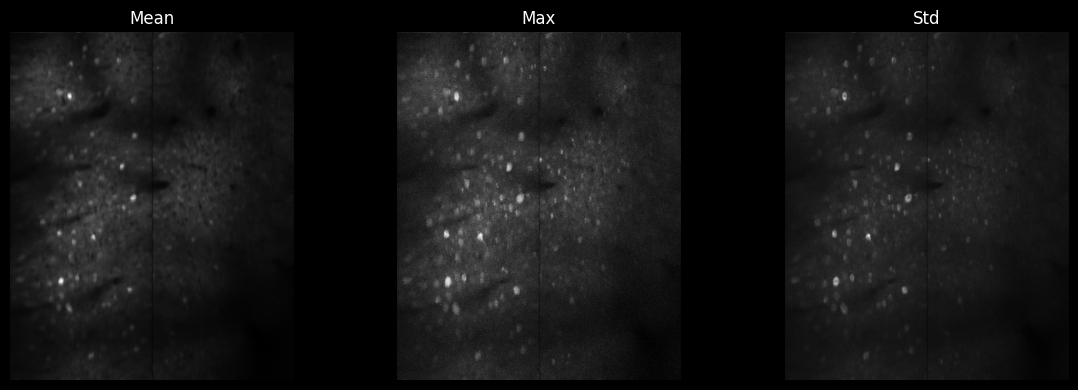

In [49]:
# Reduction operations
mean_img = arr[:200, 0, :, :].mean(axis=0).squeeze()
max_img = arr[:200, 0, :, :].max(axis=0).squeeze()
std_img = arr[:200, 0, :, :].std(axis=0).squeeze()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(mean_img, cmap='gray'); axes[0].set_title('Mean')
axes[1].imshow(max_img, cmap='gray'); axes[1].set_title('Max')
axes[2].imshow(std_img, cmap='gray'); axes[2].set_title('Std')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

## Accessing metadata

`mbo.imread` automatically collects all available metadata in the file.

All lazy-arrays have metadata available as a property:

```python
metadata = lazy_array.metadata
print(metadata["num_frames"])
>>> 1500
```

This metadata reflects information on all the options selected and otherwise available in ScanImage, for an image acquisition, as well as specific parameters that pertain to the current parameter set e.g. number of rois, number of frames, scan-phase correction properties, etc.

There is a **lot** of ScanImage metadata, even after cleaning empty values.

To view metadata, it's helpful to use [pprint](https://docs.python.org/3/library/pprint.html) so that the scanimage metadata doesn't flood the terminal.

You can quickly view metadata via the GUI Widgets:

```bash
uv run mbo D:/demo/raw --metadata
```

Or via `info`:
```bash
uv run mbo info D:/demo/raw
```

In [28]:
from pprint import pprint
pprint(arr.metadata, depth=1)

{'PhysicalSizeX': 2.0,
 'PhysicalSizeXUnit': 'micrometer',
 'PhysicalSizeY': 2.0,
 'PhysicalSizeYUnit': 'micrometer',
 'PhysicalSizeZ': 5.0,
 'PhysicalSizeZUnit': 'micrometer',
 'border': 3,
 'dtype': 'int16',
 'dx': 2.0,
 'dy': 2.0,
 'dz': 5.0,
 'file_paths': [...],
 'fix_phase': True,
 'fov': [...],
 'fov_px': [...],
 'frame_rate': 13.99553782981917,
 'frames_per_file': [...],
 'max_offset': 4,
 'mean_subtraction': False,
 'ndim': 2,
 'nframes': 1574,
 'num_files': 2,
 'num_fly_to_lines': 16,
 'num_frames': 1574,
 'num_planes': 14,
 'num_rois': 2,
 'objective_resolution': 61,
 'offset': np.float64(1.0),
 'page_height': 1116,
 'page_width': 224,
 'phasecorr_method': 'mean',
 'pixel_resolution': (...),
 'roi_groups': [...],
 'roi_heights': [...],
 'si': {...},
 'size': 249984,
 'umPerPixX': 2.0,
 'umPerPixY': 2.0,
 'umPerPixZ': 5.0,
 'uniform_sampling': 1,
 'upsample': 5,
 'use_fft': False,
 'voxel_size': (...),
 'z_step': 5.0,
 'zoom_factor': 2}


## Saving data: Formats and Conversions

Convert between any supported formats with `imwrite()`.

Here, we load the .zarr previously saved, add some metadata, and re-save to several of the supported formats.

Note: Keep different filetypes in separate directories.

In [20]:
# Load the zarr we saved earlier
arr = mbo.imread(SAVE_PATH / "plane07_stitched.zarr")

new_metadata = {"test": [123]}

# Convert to different formats (each in its own directory)
mbo.imwrite(arr, SAVE_PATH / "tiff", ext=".tiff", overwrite=True, metadata=new_metadata)
mbo.imwrite(arr, SAVE_PATH / "hdf5", ext=".h5", overwrite=True, metadata=new_metadata)
mbo.imwrite(arr, SAVE_PATH / "suite2p", ext=".bin", overwrite=True, metadata=new_metadata)

print(f"New metadata: {mbo.imread(SAVE_PATH / "tiff").metadata["test"]}")

Saving plane01.tiff:   0%|          | 0/1 [00:00<?, ?it/s]

Saving plane01.h5:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

New metadata: [123]


## User Interface: MBO-GUI

The mbo_utilities GUI can be opened in Jupyter Lab (NOT VSCode):

```python
mbo.run_gui(arr)
```

You can also run `mbo_utilities` commands with your ennvironment activated, or with uv:

```bash
uv run mbo D:/demo/planes/plane07_stitched.zarr
```

In [27]:
# To run from the command line, through jupyter:
!uv run mbo --help

Usage: mbo [OPTIONS] COMMAND [ARGS]...

  MBO Utilities CLI - data preview and processing tools.

  GUI Mode:
    mbo                            Open file selection dialog
    mbo /path/to/data              Open specific file in GUI
    mbo /path/to/data --metadata   Show only metadata

  Commands:
    mbo convert INPUT OUTPUT       Convert between formats
    mbo info INPUT                 Show array information (CLI)
    mbo formats                    List supported formats

  Utilities:
    mbo --download-file URL -o /path/   Download file from GitHub
    mbo --download-notebook             Download user guide notebook
    mbo --check-install                 Verify installation

Options:
  --download-notebook   Download the user guide notebook and exit.
  --notebook-url TEXT   URL of notebook to download.
  --download-file TEXT  Download a file from URL (e.g. GitHub).
  -o, --output TEXT     Output path for --download-file or --download-
                        notebook.
  --check-i

In [24]:
!uv run mbo info D:/demo/raw

Loading: D:/demo/raw

Array Information:
  Type:  MboRawArray
  Shape: (1574, 14, 550, 448)
  Dtype: int16
  Ndim:  4
  Files: 2
    - D:\demo\raw\demo_mk355_7_27_2025_00001.tif
    - D:\demo\raw\demo_mk355_7_27_2025_00002.tif

Metadata:
  nframes: 1574
  num_frames: 1574
  num_rois: 2
  ... and 42 more keys



Counting frames: 100%|██████████| 2/2 [00:00<?, ?it/s]


## Special array characteristics

Lazy arrays have special characteristics depending on what the filetype is used for.

### Bi-directional Scan-phase correction (ScanImage Tiff)

ScanImage Tiffs (MboRawArray) only.

Bidirectional scanning creates phase offsets between alternating lines:

![Scan phase correction](../docs/_images/corr_nocorr_phase_example.png)

Counting frames:   0%|          | 0/2 [00:00<?, ?it/s]

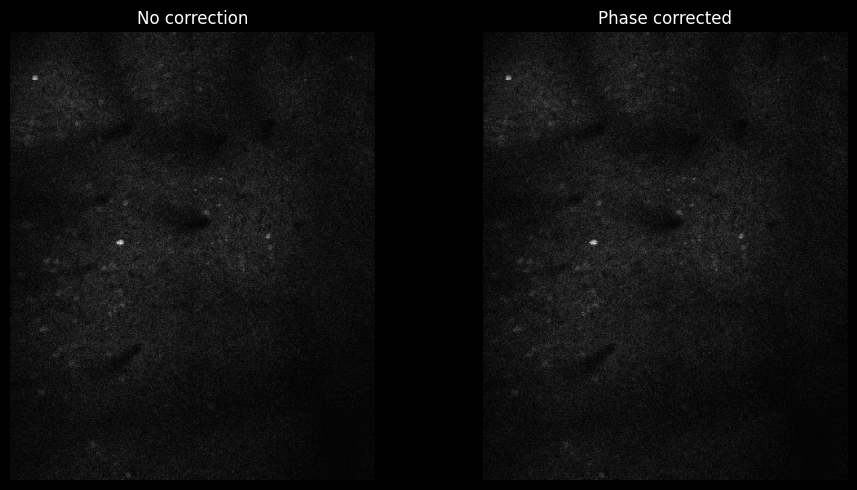

In [ ]:
arr.roi = None
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

arr.fix_phase = False
img_no_corr = arr[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[0].imshow(img_no_corr, cmap='gray')
axes[0].set_title('No Scan-Phase Correction', fontsize=12, fontweight='bold')
axes[0].axis('off')

arr.fix_phase = True
arr.use_fft = False
img_corr = scan[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[1].imshow(img_corr, cmap='gray')
axes[1].set_title('With Scan-Phase Correction', fontsize=12, fontweight='bold')
axes[1].axis('off')

scan.fix_phase = True
scan.use_fft = True
img_fft = scan[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[2].imshow(img_fft, cmap='gray')
axes[2].set_title('FFT Scan-Phase Correction\n(Best, Slower)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# clear out these large arrays in memory
del img_no_corr, img_corr, img_fft

### Multi-ROI handling (ScanImage Tiff)

Control how multiple ROIs are handled.

By default, they are stitched horizontally:

![ROI assembly](../docs/_images/assembly_1.png)

In [25]:
arr = mbo.imread(RAW_PATH)
print(f"ROIs: {arr.num_rois}")

# roi=None: Stitch horizontally (default)
arr.roi = None
print(f"Stitched shape: {arr[0, 7].shape}")

# roi=0: Split into separate arrays
arr.roi = 0
roi1, roi2 = arr[0, 7]
print(f"Split shapes: {roi1.shape}, {roi2.shape}")

# roi=N: Select specific ROI (1-indexed)
arr.roi = 1
print(f"ROI 1 only: {arr[0, 7].shape}")

Counting frames:   0%|          | 0/2 [00:00<?, ?it/s]

ROIs: 2
Stitched shape: (550, 448)
Split shapes: (550, 224), (550, 224)
ROI 1 only: (550, 224)


### Axial registration (ScanImage Tiff: Suite3D)

Light-beads-microscopy acquisition typically results in each z-plane having a spatial shift relative to adjacent planes. This can be corrected automatically by setting `register_z=True`.

Suite3D creates a `s3d-preprocessed` directory containing planar shifts and intermediates. During writing, these shifts are loaded and applied to selected z-planes.

In [ ]:
arr = mbo.imread(RAW_PATH)
arr.roi = None
arr.fix_phase = True

mbo.imwrite(
    arr,
    SAVE_PATH / "zreg",
    ext='.zarr',
    num_frames=100,
    planes=[6, 7, 8],
    overwrite=True,
    register_z=True,  # Enable Suite3D axial registration
)

# Check outputs
print("Output directories:")
for p in (SAVE_PATH / "zreg").iterdir():
    print(f"  {p.name}")

In [ ]:
# Load Suite3D registration summary
summary_path = SAVE_PATH / "zreg" / "s3d-preprocessed" / "summary" / "summary.npy"
if summary_path.exists():
    summary = np.load(summary_path, allow_pickle=True).item()

    plane_shifts = summary['plane_shifts']
    print(f"Plane shifts (Y, X):\n{plane_shifts}")

    # Visualize before/after registration
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(summary['raw_img'].max(axis=0), cmap='gray')
    axes[0].set_title('Before registration (max proj)')
    axes[1].imshow(summary['ref_img_3d'].max(axis=0), cmap='gray')
    axes[1].set_title('After registration (max proj)')
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

## Visualizations

In [ ]:
# Load Suite2p volume directory
# Any lazy array works here
from mbo_utilities import imread
import napari

arr = imread(r"D:\example_extraction\suite2p")

# Get pixel resolution from metadata (um/px)
pixel_resolution = arr.metadata.get("pixel_resolution", 1.0)  # XY resolution
z_resolution = 15.0  # um/px in Z (adjust for your data)

# Scale: (Z, Y, X) in um/px
scale = (1, 16, 2, 2)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(
    arr,
    name="Volume",
    scale=scale,
    interpolation3d="cubic",
)
viewer.show(block=True)

Inconsistent frame counts across planes: [1574, 1500, 1574, 1574, 1574, 1500, 1500, 1574, 1574, 1574, 1574, 1574, 1574, 1574]. Using minimum: 1500


### Fastplotlib (Jupyter/Command line only)

Interactive pixel trace visualization with [fastplotlib](https://www.fastplotlib.org/):

In [ ]:
import fastplotlib as fpl
from ipywidgets import VBox

arr = mbo.imread(SAVE_PATH / "plane07_stitched.zarr")
iw_movie = fpl.ImageWidget(arr[:], cmap="viridis")
tfig = fpl.Figure()
raw_trace = tfig[0, 0].add_line(np.zeros(arr.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] = iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])

---
## What's next

- [LBM-Suite2p-Python](https://github.com/MillerBrainObservatory/LBM-Suite2p-Python) - ROI detection and signal extraction
- [API Reference](https://millerbrainobservatory.github.io/mbo_utilities/)